### the conclusion

The assumptions:

flare 300 years ago + weaker recent activity
main source SgrA*

density 1e3 cm-3
soft photon field R3 from Jims paper
magnetic field 10-1e3 micro G

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import astropy.units as u

import sys
sys.path.append('/home/woody/caph/mppi062h/software/gamera/GAMERA/lib')

In [2]:
names= ['Fermi', 'HESS']
colors = ['red', 'blue']
unit_y= 'erg/cm2/s'
unit_x = 'eV'

In [3]:
flux_points = []
for name in names:
    with open(f'data_from_paper/{name}.csv', newline='') as csvfile:
        reader = csv.reader(csvfile)
        fp_name = []
        for row in reader:
            fp_name.append(row)
    flux_points.append(np.asarray(fp_name, dtype=float))

Text(0.5, 1.0, 'plot from paper')

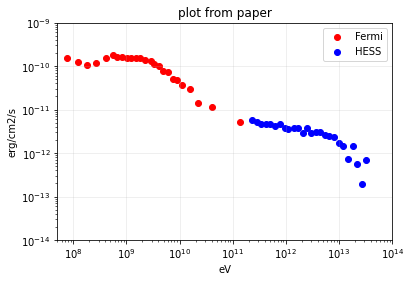

In [4]:
for i, fp_name in enumerate(flux_points):
    plt.scatter(fp_name[:, 0], fp_name[:, 1], color=colors[i], label=names[i])
plt.ylabel(unit_y)
plt.xlabel(unit_x)
plt.grid(alpha=0.25)
plt.ylim(1e-14, 1e-9)
plt.xlim(5e7, 1e14)
plt.legend()
plt.loglog()
plt.title('plot from paper')

### introdcuting gamera package

In [5]:
import sys
sys.path.append('/home/woody/caph/mppi062h/software/gamera/GAMERA/lib')
import gappa as gp

In [6]:
# general parameters
fu = gp.Utils()
e_ref = 1*gp.TeV_to_erg # define reference energy as 100 TeV
bins = 500
energy_in_erg_pl = np.logspace(-6,3,bins) * gp.TeV_to_erg 

In [7]:
# general environment parameters

b_field = 2.5e-4 # in Gauss, necessary for Synchrotron calculation
density = 1e3 # 1/cm^3, necessary for Bremsstrahlung and hadronic emission
# radiation field parameters, necessary for Inverse-Compton radiation. 
age = 1e4 # yrs time to cool down with IC
distance = 8e3 # in pc

# describing region R4 from paper
t_gen= 0.5; edens_gen = 5e4*gp.eV_to_erg

t_cmb = 2.7; edens_cmb = 0.26*gp.eV_to_erg
t_UV = 3; edens_UV= 5e4*gp.eV_to_erg
t_NIR = 0.3; edens_NIR= 5e4*gp.eV_to_erg
t_FIR = 6e-3; edens_FIR= 5e2*gp.eV_to_erg

### first component: the flare

In [8]:
# Defining particle spectrum
alpha_pl = 1.5
e_total_pl = 2e39 # erg/s 
fraction_weak = 1e-2
flare_duration= 10
starting_time_flare= 300

E_0 = 100*gp.TeV_to_erg

power_law = ((energy_in_erg_pl/e_ref)**-alpha_pl)
power_law *= e_total_pl / fu.Integrate(list(zip(energy_in_erg_pl,power_law * energy_in_erg_pl)))
power_law_spectrum = np.array(list(zip(energy_in_erg_pl,power_law)))

fp = gp.Particles()

In [9]:
flare_time = age-starting_time_flare-flare_duration
time_steps_big = np.logspace(0,np.log10(flare_time),100) #in years
time_steps_fine = np.logspace(np.log10(flare_time),np.log10(age),100) #in years
time_steps = np.concatenate([time_steps_big[:-1], time_steps_fine])

In [10]:
# set the fields in the Radiation object
fp.SetBField(b_field)
fp.SetAmbientDensity(density)
fp.SetAge(age)

#fp.AddThermalTargetPhotons(t_gen,edens_gen,bins)

fp.AddThermalTargetPhotons(t_UV,edens_UV,bins)
fp.AddThermalTargetPhotons(t_FIR,edens_FIR,bins)
fp.AddThermalTargetPhotons(t_NIR,edens_NIR,bins)
fp.AddThermalTargetPhotons(t_cmb,edens_cmb,bins)

Radiation::AddThermalTargetPhotons: energy density of radiation field insane. Are you sure of this?


In [11]:
fp.SetCustomInjectionSpectrum(power_law_spectrum)

dens_lum = np.asarray([e_total_pl if (t >= age-starting_time_flare and t<= age-starting_time_flare+flare_duration) else e_total_pl*fraction_weak for t in time_steps])
dens = list(zip(time_steps,dens_lum))
fp.SetLuminosity(dens)

fp.SetSolverMethod(1)
fp.CalculateElectronSpectrum()

sp = np.array(fp.GetParticleSpectrum())
sed = np.array(fp.GetParticleSED())

Radiation::AddThermalTargetPhotons: energy density of radiation field insane. Are you sure of this?
___________________________________
>> STARTING NEW PARTICLE EVOLUTION 
   (-> electrons)     
>> CALCULATING IC LOSS LOOKUP 
    99% done
    -> DONE!   

>> COMPUTATION OF IC LOSS LOOKUP COMPLETE 

** Evolving Electron Spectrum:
>> PARTICLE EVOLUTION DONE. EXITING.



In [12]:
fr = gp.Radiation()
fr.AddArbitraryTargetPhotons(fp.GetTargetPhotons()) # output from 'Particles' is in the right format to be used in 'Radiation'
fr.SetBField(b_field)

fr.SetAmbientDensity(density)
fr.SetDistance(distance) # optional, in parsec. If not set or equals zero, luminosity instead of flux will be calculated
fr.SetElectrons(sp)
fr.CalculateDifferentialPhotonSpectrum(np.logspace(-19,3,int(bins/2)) * gp.TeV_to_erg)

_________________________________________
>> CALCULATING SED FROM PARENT PARTICLES 
** Calculating differential gamma-ray emission:
    129 / 250 points calculated

In [13]:
tot = np.array(fr.GetTotalSED())
ic = np.array(fr.GetICSED())
brems = np.array(fr.GetBremsstrahlungSED())
synch = np.array(fr.GetSynchrotronSED())

    250 / 250 points calculated
    -> DONE!   

>> SED CALCULATION DONE. EXITING.



Text(0.5, 1.0, 'Radiation SED (10000.0yrs)')

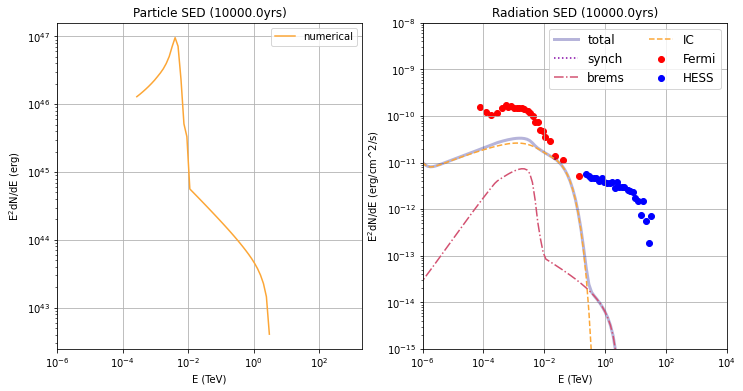

In [14]:
#### make a plot #####
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))
ax1.set_prop_cycle('color',plt.get_cmap('plasma_r')(np.linspace(0.2, .8, 2)))  #
ax1.loglog(sed[:,0],sed[:,1],ls="-",label="numerical")
#ax1.loglog(sed_s[:,0],sed_s[:,1],ls=":",label="semianalytic")
ax1.set_xlabel("E (TeV)")
ax1.set_ylabel("E"+r"$^2$"+"dN/dE (erg)")
ax1.grid()
ax1.legend()
ax1.set_xlim(xmin=1e-6,xmax=2e3)
#ax1.set_ylim(ymin=1e44,ymax=1e48)
ax1.set_title("Particle SED ("+ str(round(age,0))+"yrs)")

ax2.set_prop_cycle('color',plt.get_cmap('plasma')(np.linspace(0., .8, 4)))  #
for i, fp_name in enumerate(flux_points):
    ax2.scatter(fp_name[:, 0]*1e-12, fp_name[:, 1], color=colors[i], label=names[i])
ax2.loglog(tot[:,0],tot[:,1],ls="-",label="total",lw=3,alpha=0.3)
ax2.loglog(synch[:,0],synch[:,1],ls=":",label="synch")
ax2.loglog(brems[:,0],brems[:,1],ls="-.",label="brems")
ax2.loglog(ic[:,0],ic[:,1],linestyle="--",label="IC")
ax2.set_xlabel("E (TeV)")
ax2.set_ylabel("E"+r"$^2$"+"dN/dE (erg/cm^2/s)")
ax2.legend(ncol=2,prop={'size':12})
ax2.grid()
ax2.set_xlim(xmin=1e-6,xmax=1e4)
ax2.set_ylim(ymin=1e-15,ymax=1e-8)
ax2.set_title("Radiation SED ("+ str(round(age,0))+"yrs)")

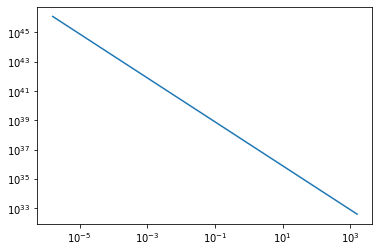

In [14]:
time_steps = np.logspace(1,6,10)

''' 
    Calculate the electron and radiation spectrum at different time steps
'''
rad = []
part = []
for t in time_steps:
    fp.SetAge(t)
    fp.CalculateElectronSpectrum()

    sp = np.array(fp.GetParticleSpectrum())
    part.append(np.array(fp.GetParticleSED()))

    fr.SetElectrons(sp)
    fr.CalculateDifferentialPhotonSpectrum(np.logspace(-19,3,int(bins/2)) * gp.TeV_to_erg)
    rad.append(np.array(fr.GetTotalSED()))


''' 
    Calculate the radiation spectrum from the previously calculated electron distribution
''' 

#### make a plot #####
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))
ax1.set_prop_cycle('color',plt.get_cmap('plasma_r')(np.linspace(0.2, .8, len(time_steps))))  #
for p,t in list(zip(part,time_steps)):
    ax1.loglog(p[:,0],p[:,1],label=str(int(t)))
ax1.set_xlabel("E (TeV)")
ax1.set_ylabel("E"+r"$^2$"+"dN/dE (erg)")
ax1.grid()
ax1.legend(ncol=2,prop={'size':10},title="age(yrs):")
ax1.set_xlim(xmin=1e-6,xmax=2e3)
ax1.set_ylim(ymin=1e40,ymax=1e52)
ax1.set_title("Particle SEDs")

ax2.set_prop_cycle('color',plt.get_cmap('plasma_r')(np.linspace(0.2, .8, len(time_steps))))  #
for r,t in list(zip(rad,time_steps)):
    ax2.loglog(r[:,0],r[:,1],label=str(int(t)))
ax2.set_xlabel("E (TeV)")
ax2.set_ylabel("E"+r"$^2$"+"dN/dE (erg/cm^2/s)")
ax2.legend(ncol=2,prop={'size':10},title="age(yrs):")
ax2.grid()
ax2.set_xlim(xmin=1e-19,xmax=1e4)
ax2.set_ylim(ymin=1e-15,ymax=1e-6)
ax2.set_title("Radiation SEDs")
f.savefig("particles_static_timeseries.png",bbox_inches='tight')

___________________________________
>> STARTING NEW PARTICLE EVOLUTION 
   (-> electrons)     
>> CALCULATING IC LOSS LOOKUP 
    99% done
    -> DONE!   

>> COMPUTATION OF IC LOSS LOOKUP COMPLETE 

** Evolving Electron Spectrum:
>> PARTICLE EVOLUTION DONE. EXITING.

Radiation::SetParticles: Overwriting existing electron lookup.
_________________________________________
>> CALCULATING SED FROM PARENT PARTICLES 
** Calculating differential gamma-ray emission:
    250 / 250 points calculatedpoints calculated
    -> DONE!   

>> SED CALCULATION DONE. EXITING.

___________________________________
>> STARTING NEW PARTICLE EVOLUTION 
   (-> electrons)     
** Evolving Electron Spectrum:
>> PARTICLE EVOLUTION DONE. EXITING.

Radiation::SetParticles: Overwriting existing electron lookup.
_________________________________________
>> CALCULATING SED FROM PARENT PARTICLES 
** Calculating differential gamma-ray emission:
    174 / 250 points calculated

KeyboardInterrupt: 

    250 / 250 points calculated
    -> DONE!   

>> SED CALCULATION DONE. EXITING.

___________________________________
>> STARTING NEW PARTICLE EVOLUTION 
   (-> electrons)     
** Evolving Electron Spectrum:
>> PARTICLE EVOLUTION DONE. EXITING.

Radiation::SetParticles: Overwriting existing electron lookup.
_________________________________________
>> CALCULATING SED FROM PARENT PARTICLES 
** Calculating differential gamma-ray emission:
    250 / 250 points calculatedulated
    -> DONE!   

>> SED CALCULATION DONE. EXITING.

___________________________________
>> STARTING NEW PARTICLE EVOLUTION 
   (-> electrons)     
** Evolving Electron Spectrum:
>> PARTICLE EVOLUTION DONE. EXITING.

Radiation::SetParticles: Overwriting existing electron lookup.
_________________________________________
>> CALCULATING SED FROM PARENT PARTICLES 
** Calculating differential gamma-ray emission:
    250 / 250 points calculated
    -> DONE!   

>> SED CALCULATION DONE. EXITING.

________________________

In [ ]:
#!/usr/local/bin/python

import sys
import os
sys.path.append(os.path.abspath('path/to/your/lib/directory'))
import gappa as gp
import numpy as np
import matplotlib.pyplot as plt

if __name__ == "__main__":

    fu = gp.Utils()
    fu.DrawGamera()

    bins = 500

    # define reference energy as 1 TeV
    e_ref = gp.TeV_to_erg

    '''
        example: define a power-law spectrum. Units:
        E(erg) - dN/dE (1/erg/s)
    '''
    logemin = -5; logemax = 3
    # it is good to add a margin at the upper end of the energy range. That is,
    # due to the algorithm, at the highest bins a downwards bias can occur. 
    energy_in_erg_pl = np.logspace(logemin,logemax,bins) * gp.TeV_to_erg 
    alpha_pl = 2; e_total_pl = 1e37 # erg
    power_law = (energy_in_erg_pl/e_ref)**-alpha_pl
    # renormalise to e_total_pl (integrate E*dN/dE over E)
    power_law *= e_total_pl / fu.Integrate(list(zip(energy_in_erg_pl,power_law * energy_in_erg_pl)))
    # cast into a 2D array
    power_law_spectrum = np.array(list(zip(energy_in_erg_pl,power_law)))


    fp = gp.Particles()

    '''
        define loss terms:
        - Synchrotron losses     <-> B-Field strength
        - Inverse-Compton losses <-> Radiation fields
        - Bremsstrahlung losses
    '''
    b_field = 1e-5 # Gauss
    density = 5 # 1/cm^3
    age = 1e4 # yrs
    distance = 1e3 # pc

    fp.SetBField(b_field)
    fp.SetAmbientDensity(density)

    ''' 
        the following are the parameters of the CMB
        See also the tutorial on how to set target fields in the GAMERA docu!
    '''
    t_cmb = 2.7; edens_cmb = 0.4*gp.eV_to_erg

    # set the fields in the Radiation object
    fp.AddThermalTargetPhotons(t_cmb,edens_cmb,bins)
    fp.SetCustomInjectionSpectrum(power_law_spectrum)

    # set up radiation object
    fr = gp.Radiation()
    fr.AddArbitraryTargetPhotons(fp.GetTargetPhotons()) # output from 'Particles' is in the right format to be used in 'Radiation'
    fr.SetBField(b_field)
    fr.SetAmbientDensity(density)
    fr.SetDistance(distance) # optional, in parsec. If not set or equals zero, luminosity instead of flux will be calculated


    time_steps = np.logspace(1,6,10)

    ''' 
        Calculate the electron and radiation spectrum at different time steps
    '''
    rad = []
    part = []
    for t in time_steps:
        fp.SetAge(t)
        fp.CalculateElectronSpectrum()
        
        sp = np.array(fp.GetParticleSpectrum())
        part.append(np.array(fp.GetParticleSED()))

        fr.SetElectrons(sp)
        fr.CalculateDifferentialPhotonSpectrum(np.logspace(-19,3,bins/2) * gp.TeV_to_erg)
        rad.append(np.array(fr.GetTotalSED()))
        
    


    ''' 
        Calculate the radiation spectrum from the previously calculated electron distribution
    ''' 

    #### make a plot #####
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))
    ax1.set_prop_cycle('color',plt.get_cmap('plasma_r')(np.linspace(0.2, .8, len(time_steps))))  #
    for p,t in list(zip(part,time_steps)):
        ax1.loglog(p[:,0],p[:,1],label=str(int(t)))
    ax1.set_xlabel("E (TeV)")
    ax1.set_ylabel("E"+r"$^2$"+"dN/dE (erg)")
    ax1.grid()
    ax1.legend(ncol=2,prop={'size':10},title="age(yrs):")
    ax1.set_xlim(xmin=1e-6,xmax=2e3)
    ax1.set_ylim(ymin=1e40,ymax=1e52)
    ax1.set_title("Particle SEDs")

    ax2.set_prop_cycle('color',plt.get_cmap('plasma_r')(np.linspace(0.2, .8, len(time_steps))))  #
    for r,t in list(zip(rad,time_steps)):
        ax2.loglog(r[:,0],r[:,1],label=str(int(t)))
    ax2.set_xlabel("E (TeV)")
    ax2.set_ylabel("E"+r"$^2$"+"dN/dE (erg/cm^2/s)")
    ax2.legend(ncol=2,prop={'size':10},title="age(yrs):")
    ax2.grid()
    ax2.set_xlim(xmin=1e-19,xmax=1e4)
    ax2.set_ylim(ymin=1e-15,ymax=1e-6)
    ax2.set_title("Radiation SEDs")
    f.savefig("particles_static_timeseries.png",bbox_inches='tight')
